# Fine-tuning EpiAgent for Unsupervised Feature Extraction on a New Dataset


In this notebook, we provide a comprehensive demonstration of how to fine-tune the **EpiAgent** model for unsupervised feature extraction on a newly sequenced single-cell ATAC-seq dataset. The EpiAgent model has been pre-trained on the large-scale **Human-scATAC-Corpus** comprising approximately **5 million cells** and **35 billion tokens**. By fine-tuning the pre-trained model on your dataset, you can enhance its performance for downstream analysis tasks specific to your data.

**Prerequisites:**

- **EpiAgent Pre-trained Model**: `pretrained_EpiAgent.pth` (can be downloaded at https://drive.google.com/drive/folders/1WlNykSCNtZGsUp2oG0dw3cDdVKYDR-iX?usp=sharing)
- **Candidate cis-Regulatory Elements (cCREs)**: `cCRE.bed` (can be downloaded at https://github.com/xy-chen16/EpiAgent/blob/main/data/cCRE.bed)
- **Sample Dataset**:

  - `Kanemaru2023_downsampled_10000_cells.h5ad` (can be downloaded at https://drive.google.com/drive/folders/1WlNykSCNtZGsUp2oG0dw3cDdVKYDR-iX?usp=sharing): The downsampled Kanemaru2023 dataset.

- **Optional Processed Dataset**:

  - `Kanemaru2023_downsampled_10000_cells_EpiAgent_zero_shot_outputs.h5ad`: Processed dataset with zero-shot feature extraction, available after running the `[Zero-shot Feature Extraction using EpiAgent.ipynb](#)` notebook. This allows comparison between zero-shot and fine-tuned embeddings.

# Step 1: Data Loading and Preprocessing


In this step, we will load the Kanemaru2023 dataset and perform necessary preprocessing to prepare it for fine-tuning with EpiAgent. The preprocessing involves converting raw count data into TF-IDF scores and tokenizing the data to create cell sentences.

**Two options are provided for data loading:**

1. **Load Preprocessed Data**: If you have already preprocessed data, you can load it directly.
2. **Load Raw Data and Preprocess**: If you have raw data, you can perform preprocessing steps as shown below.


## Option 1: Load Preprocessed Data

In [1]:
import scanpy as sc

# Load the preprocessed AnnData
input_path = '../data/sample/processed_h5ad/Kanemaru2023_downsampled_10000_cells_EpiAgent_zero_shot_outputs.h5ad'
adata = sc.read_h5ad(input_path)

## Option 2: Load Raw Data and Perform Preprocessing

To prepare the Kanemaru2023 dataset for EpiAgent, we perform the following preprocessing steps:

1. **TF-IDF Transformation**: Convert discrete count data into continuous importance scores for accessible cCREs.
2. **Tokenization**: Generate `cell_sentences` to represent each cell as a sequence of accessible cCRE indices.

In [2]:
# import scanpy as sc
# import numpy as np
# from epiagent.tokenization import tokenization
# from epiagent.preprocessing import global_TFIDF

# # Load the raw dataset
# input_path = '../data/sample/raw_h5ad/Kanemaru2023_downsampled_10000_cells.h5ad'
# adata = sc.read_h5ad(input_path)

# # Load the cCRE document frequency data
# cCRE_document_frequency = np.load('../data/cCRE_document_frequency.npy')

# # Apply TF-IDF transformation
# global_TFIDF(adata, cCRE_document_frequency)

# # Perform tokenization to create cell sentences
# tokenization(adata)

Tokenization complete: 'cell_sentences' column added to adata.obs.


# Step 2: Create Datasets and DataLoaders
In this step, we create PyTorch datasets and dataloaders required for training and inference. We use different dataset classes for training (`CellDatasetForUFE`) and inference (`CellDataset`) purposes.

## Create Training Dataset and DataLoader

We use the `CellDatasetForUFE` class to prepare the dataset for fine-tuning, which requires both the cCRE indices and the signal information from `adata`.

In [2]:
from epiagent.dataset import CellDatasetForUFE, collate_fn_for_UFE
from torch.utils.data import DataLoader

# Extract cell sentences from the AnnData object
cell_sentences = adata.obs['cell_sentences'].tolist()

# Create the training dataset
train_cell_dataset = CellDatasetForUFE(
    adata=adata,
    cell_sentences=cell_sentences,
    max_length=8192,
    alpha_for_CCA=1,
    num_cCRE=1355445,
    is_random=False
)

# Create the training DataLoader
train_batch_size = 5
train_dataloader = DataLoader(
    train_cell_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=16,
    collate_fn=collate_fn_for_UFE
)

## Create Inference Dataset and DataLoader

For inference, we use the `CellDataset` class, which only requires the tokenized cell sentences.

In [3]:
from epiagent.dataset import CellDataset, collate_fn

# Create the inference dataset
inference_cell_dataset = CellDataset(
    cell_sentences=cell_sentences,
    max_length=8192,
    is_random=False
)

# Create the inference DataLoader
inference_batch_size = 8
inference_dataloader = DataLoader(
    inference_cell_dataset,
    batch_size=inference_batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

# Step 3: Load the Pre-trained EpiAgent Model

We load the pre-trained EpiAgent model, which was trained on the Human-scATAC-Corpus, and prepare it for fine-tuning.

In [4]:
from epiagent.model import EpiAgent
import torch

# Specify the path to the pre-trained model
model_path = '../model/pretrained_EpiAgent.pth'

# Set the device (GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the EpiAgent model with appropriate configurations
pretrained_model = EpiAgent(
    vocab_size=1355449,
    num_layers=18,
    embedding_dim=512,
    num_attention_heads=8,
    max_rank_embeddings=8192,
    use_flash_attn=True,
    pos_weight_for_RLM=torch.tensor(1.),
    pos_weight_for_CCA=torch.tensor(1.)
)

# Load the pre-trained weights into the model
pretrained_model.load_state_dict(torch.load(model_path))

# Ensure the CCA loss uses a positive weight of 1
pretrained_model.criterion_CCA.pos_weight = torch.tensor(1.)

# Move the model to the specified device
pretrained_model.to(device)

EpiAgent(
  (cCRE_embedding): Embedding(1355449, 512)
  (rank_embedding): Embedding(8192, 512)
  (EpiAgent_transformer): BertEncoder(
    (layers): ModuleList(
      (0-17): 18 x Block(
        (mixer): MHA(
          (Wqkv): LinearResidual(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashSelfAttention(
            (drop): Dropout(p=0.1, inplace=False)
          )
          (inner_cross_attn): FlashCrossAttention(
            (drop): Dropout(p=0.1, inplace=False)
          )
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (drop_path1): StochasticDepth(p=0.0, mode=row)
        (norm1): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout2): Dropout(p=0.1, inplace=False)
        (d

# Step 4: Fine-tuning the EpiAgent Model

We now fine-tune the pre-trained EpiAgent model using the prepared training data. The fine-tuning process adjusts the model weights to better capture the patterns specific to the new dataset.

In [5]:
from epiagent.train import fine_tune_epiagent_for_UFE

# Fine-tune the model
fine_tuned_model = fine_tune_epiagent_for_UFE(
    model=pretrained_model,
    train_dataloader=train_dataloader,
    num_steps=200000, 
    save_dir='../model/fine_tune/UFE/demo_dataset/',
    device=device,
    learning_rate=1e-4,
    save_steps=20000,
    log_steps=500,
    warmup_steps=10000,
    is_logging=True
)

Model directory created at: ../model/fine_tune/UFE/demo_dataset/


Epoch [1/19], Step [500/2001], Total Loss: 1.3276, CCA Loss: 0.5481, SR Loss: 0.7795
CCA Metrics - Positive Acc: 0.6568, Negative Acc: 0.8047, AUROC: 0.8066, AUPRC: 0.8261
Epoch [1/19], Step [1000/2001], Total Loss: 1.3044, CCA Loss: 0.5367, SR Loss: 0.7677
CCA Metrics - Positive Acc: 0.7390, Negative Acc: 0.8166, AUROC: 0.8480, AUPRC: 0.8664
Epoch [1/19], Step [1500/2001], Total Loss: 1.2660, CCA Loss: 0.5235, SR Loss: 0.7425
CCA Metrics - Positive Acc: 0.7208, Negative Acc: 0.7578, AUROC: 0.8227, AUPRC: 0.8407
Epoch [1/19], Step [2000/2001], Total Loss: 1.2412, CCA Loss: 0.5167, SR Loss: 0.7245
CCA Metrics - Positive Acc: 0.7263, Negative Acc: 0.6821, AUROC: 0.7889, AUPRC: 0.8353
End of Epoch 1/19, Total Loss: 2570.3581, CCA Loss: 1063.0406, SR Loss: 1507.3175
Epoch [2/19], Step [499/2001], Total Loss: 1.2251, CCA Loss: 0.5128, SR Loss: 0.7124
CCA Metrics - Positive Acc: 0.7417, Negative Acc: 0.7131, AUROC: 0.8103, AUPRC: 0.8490
Epoch [2/19], Step [999/2001], Total Loss: 1.2175, CCA 

**Note:**

- The `fine_tune_epiagent_for_UFE` function handles the training process, including logging and model checkpointing.
- The model checkpoints will be saved in the specified `save_dir`.


## Step 5: Extract Cell Embeddings Using the Fine-tuned Model

After fine-tuning, we use the updated model to extract cell embeddings that reflect the cell-specific regulatory patterns in the new dataset.

In [6]:
from epiagent.inference import infer_cell_embeddings

# Extract cell embeddings using the fine-tuned model
cell_embeddings = infer_cell_embeddings(fine_tuned_model, device, inference_dataloader)

# Assign the embeddings to the AnnData object
adata.obsm['cell_embeddings_fine_tuned'] = cell_embeddings

## Step 6: Visualize the Cell Embeddings with UMAP

We perform dimensionality reduction using UMAP to visualize the cell embeddings and assess the model's performance in capturing biological variability.


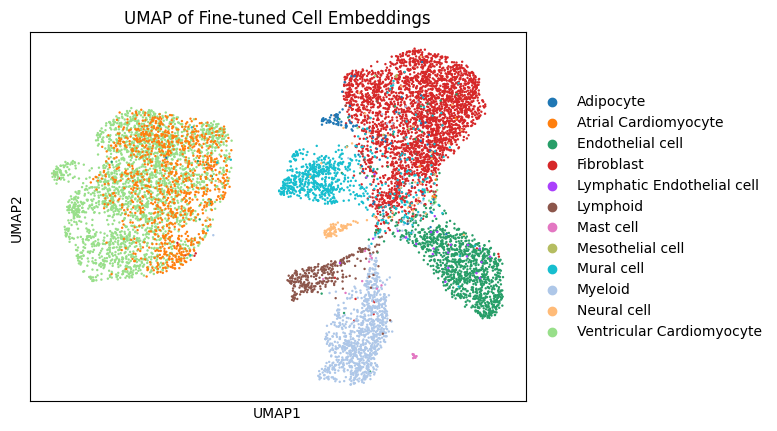

In [7]:
import scanpy as sc

# Compute the neighborhood graph using the fine-tuned embeddings
sc.pp.neighbors(adata, use_rep='cell_embeddings_fine_tuned')

# Generate the UMAP embedding
sc.tl.umap(adata)

# Plot UMAP colored by cell type
sc.pl.umap(adata, color='cell_type', title='UMAP of Fine-tuned Cell Embeddings')

## Optional: Save the Processed AnnData Object

You may choose to save the `AnnData` object with the new cell embeddings for future analysis.

In [8]:
# Save the processed AnnData
output_path = '../data/sample/processed_h5ad/Kanemaru2023_downsampled_10000_cells_EpiAgent_fine_tuned_outputs.h5ad'
adata.write(output_path)
print(f"Processed AnnData saved at {output_path}")

Processed AnnData saved at ../data/sample/processed_h5ad/Kanemaru2023_downsampled_10000_cells_EpiAgent_fine_tuned_outputs.h5ad
